# A Toy Problem - Enhanced Sampling

## Framing the Problem

Consider a system with two degrees of freedom with Hamiltonian:
$$
    H = \frac{px^2}{2m_x}\ + \frac{py^2}{2m_y}\ + \frac{D_0}{a^4}(x^2-a^2)^2 + \frac{1}{2}m_y\omega^2y^2 + \lambda xy
$$

We can see the potential energy is:
$$
   U(x, y) = \frac{D_0}{a^4}(x^2-a^2)^2 + \frac{1}{2}m_y\omega^2y^2 + \lambda xy 
$$

We want to calculate the marginal probability distribution function:
$$
    P(x) = \int dy e^{-\beta U(x, y)}
$$

So that we can ascertain the potential energy surface *A* of our system:
$$
    A(x) = -\frac{1}{\beta}lnP(x)

## Analytical Solution

To begin, I will calculate the marginal probability distribution analytically. This will serve as a benchmark value that I can compare to the results that I will simulate.

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from statsmodels.distributions.empirical_distribution import ECDF
import gc
from scipy.optimize import curve_fit

In [8]:
# Constants
d = 5
a = 1
omega = 1
lam = 2.878

# Function for the potential energy of the system
def potential_energy(x, y, m_x, m_y):
    '''
    Function to return the potential energy of system

    @param x : x coordinate
    @param y : y coordinate
    @param m_x : mass in x
    @param m_y : mass in y
    @return en : potential energy
    '''

    # Calculate energy
    en = (d * ((x ** 2) - (a ** 2)) ** 2) + (0.5 * m_y * (omega ** 2) * (y ** 2)) + (lam * x * y)

    # Return energy
    return en

# Function for total energy
def total_energy(x, y, p_x, p_y, m_x, m_y):
    '''
    Function to return total energy of the system

    @param x : x-coordinate
    @param y : y-coordinate
    @param p_x : momentum in x
    @param p_y : momentum in y
    @param m_x : mass in x
    @param m_y : mass in y
    @return en : total energy
    '''

    # Calculate energy
    en = ((p_x ** 2) / (2 * m_x)) + ((p_y ** 2) / (2 * m_y)) + potential_energy(x, y, m_x, m_y)

    # Return energy
    return en

With a function to calculate potential energy, I will integrate analytically with respect to y to obtain the marginal probability distribution *P(x)* and, consequently, the free energy surface *A(x)*. This will later be compared to the result obtained by am dynamics simulation. Note that I performed integration with Mathematica due to it's superior integration capabilities compared to python libraries like SymPy.

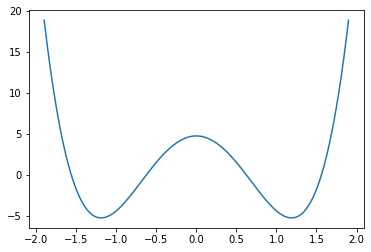

In [32]:
# Plotting Free Energy Surface
x_list = np.linspace(-1.9, 1.9, 1000)
fes = - np.log(1.25331 * np.exp(-((d * (a ** 2 - x_list ** 2) ** 2) / (a ** 4)) + ((0.5 * (x_list ** 2) * (lam ** 2)) / (1 * (omega ** 2)))) / (np.sqrt(1) * omega)) / 1
pe = potential_energy(x_list, 0, 1, 1)
plt.plot(x_list, fes)
#plt.plot(x, pe, linestyle='--')
plt.show()

## Numerical Solution

A numerical solution to finding the free energy surface and marginal probability distribution of the system outlined above is to simulate it with a molecular dynamics approach. By propagating a particle in time over a range of x and y values, the probability distribution along those points can be ascertained. In this problem, I will generate a particle that can move in two directions: x and y, Based on the potential acting on this particle, it's position and momentum will change in time. Specifically, I will use Langevin dynamics to propagate this particle. In Langevin dynamics, a "stochastic-dynamical" system involving position and momentum can be modeled equations:
$$
    dx = M^{-1} p dt
$$
$$
    dp = [- \nabla U(x) - \gamma] dt + \sigma M^{1/2} dW
$$
Where dx and dp are changes in position and momentum respectively, M is a mass or diagonal matrix of masses, gamma is a friction coefficient, and W is a Wiener process or a vector of Wiener processes. Leimkuhler and Matthews derive the equations of motion (EOMs) shown above for Langevin dynamical systems. These equations maintain temperature by modulating the momentum of the system.

### My algorithm

1. Initialize coordinate, choose v<sub>x</sub> and v<sub>y</sub>.
2. Compute forces $$F = -\nabla U(x, y)$$
3. Update position and momentum (BAOAB integrator, follows from Langevin Dynamics)
4. Update time $$ t = t + \Delta t$$
5. Repeat steps 2 through 4 for n timesteps.

## Langevin Dynamics

I will be implementing the BAOAB integrator, these equations below follow from Langevin dynamics. This integrator has the following equations of motion:

$$
    p_{n+1/2} = p_n - \delta t \nabla U(x_n)/2:
$$
$$
    x_{n+1/2} = x_n + \delta t M^{-1} p_{n+1/2}/2;
$$
$$
    \hat{p}_{n+1/2} = c_1 p_{n+1/2} + c_3 M^{1/2} R_{n+1};
$$
$$
    x_{n+1} = x_{n+1/2} + \delta t M^{-1} \hat{p}_{n+1/2}/2;
$$
$$
    p_{n+1} = \hat{p}_{n+1/2} - \delta t \nabla U(x_{n+1})/2;
$$

Where:
$$
    c_1 = e^{-\gamma \delta t}, \quad c_2 = \gamma^{-1}(1-c_1), \quad c_3 = \sqrt{k_BT(1-c_1^2)}
$$

where I will set &gamma; to be 1

A numerical solution requires simulating a particle in the x and y space we have constrained our system to. In order to do this we must initialize a system with x and y coordinates at time of 0 seconds. We also need to specify temperature and masses for x and y directions.

In [9]:
def grad(point, m_y):
    '''
    Function to calculate the gradient of the potential V(x, y) with respect to x

    @param point : point to evaluate gradient
    @param m_y : mass in y
    @return grad : the gradient
    '''

    # Set x and y
    x = point[0]
    y = point[1]

    # Calculate gradient
    grad_x = (((4 * d) / (a ** 4)) * x * ((x ** 2) - (a ** 2))) + (y * lam)
    grad_y = ((m_y * (omega ** 2) * y) + (lam * x))
    gradient = (grad_x, grad_y)

    # Return gradient
    return gradient

def run_simulation(n_steps, m_x, m_y, kt_x, kt_y):
    '''
    Function to run simulation for x timesteps

    @param n_steps : number of timesteps to take
    @param m_x : mass for x-coordinate
    @param t_x : temperature for x-coordinate
    @param m_y : mass for y-coordinate
    @param t_y : temperature for y_coordinate

    @return x_pos : x-coordinate data
    @return free_en : free energy at each x position
    '''

    # Lists for data collection 
    steps = []  # Number of steps
    x_pos = []  # Values for x at each step
    p_square = []   # Momentum squared at each step
    velo = []   # Velocity list

    '''
    Step 1: Initialize system

    Set coordinate and choose a random velocity to initialize system, momenta will
    evolve through equations of motion after this step so velocity does not need to be
    tracked throughout the simulation.
    '''
    coords = [-1, 1]
    velocity = [random.gauss(0, 1), random.gauss(0, 1)]
    momenta = [m_x * velocity[0], m_y * velocity[1]]
    time = 0
    time_step = 0.30 * (10 ** -3)

    # Initialize constants
    c1 = np.exp(-1 * time_step)
    c3_x = np.sqrt(kt_x * (1 - (c1 ** 2)))
    c3_y = np.sqrt(kt_y * (1 - (c1 ** 2)))

    # Simulation loop
    for i in range(n_steps):

        '''
        Step 2: Compute forces

        Forces are negative gradient of the potential.
        '''
        gradient = grad(coords, m_y)

        '''
        Step 3: Move coordinate
        
        Integrate the Langevin dynamics equations of motion to conserve momenta and, thus, temperature.
        '''
        # B
        p_int_x = momenta[0] - (time_step * gradient[0]) / 2
        p_int_y = momenta[1] - (time_step * gradient[1]) / 2
 
        # A
        x_int = coords[0] + (time_step * (m_x ** -1) * p_int_x) / 2
        y_int = coords[1] + (time_step * (m_y ** -1) * p_int_y) / 2

        # O
        p_int_x = (c1 * p_int_x) + (c3_x * (m_x ** (1/2)) * random.gauss(0, 1))
        p_int_y = (c1 * p_int_y) + (c3_y * (m_y ** (1/2)) * random.gauss(0, 1))

        # A
        x_new = x_int + (time_step * (m_x ** -1) * p_int_x) / 2
        y_new = y_int + (time_step * (m_y ** -1) * p_int_y) / 2

        # Compute NEW gradient for final equations
        new_gradient = grad([x_new, y_new], m_y)

        # B
        p_new_x = p_int_x - (time_step * new_gradient[0]) / 2
        p_new_y = p_int_y - (time_step * new_gradient[1]) / 2

        # Set new coordinates and momenta
        coords[0], coords[1] = x_new, y_new
        momenta[0], momenta[1] = p_new_x, p_new_y

        '''
        Step 4: Accelerate time
        
        Add timestep to current time.
        '''
        time = time + time_step

        # Record values and repeat
        steps.append(i+1)
        x_pos.append(coords[0])
        p_square.append(momenta[0] ** 2)
        velo.append(momenta[0] / m_x)
        
    # Return data
    return x_pos, p_square, velo, steps

## Simulation Testing

Below is code for testing the simulation written above and analyzing resulting data. Relevant figures like x position over time can be generated and used to visualize the movement of the particle and the free energy of the system.

In [35]:
# Run simulation as test
n_steps = 150000000
x, p_square, velo, steps = run_simulation(n_steps, 300, 1, 20, 1)

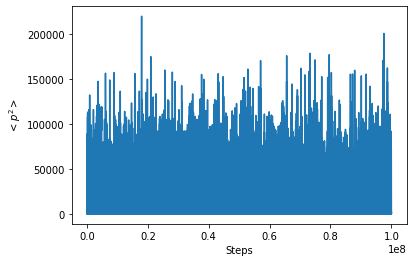

In [14]:
# Plot momentum squared over time
plt.xlabel('Steps')
plt.ylabel('$<p^{2}>$')
plt.plot(steps, p_square)
plt.show()

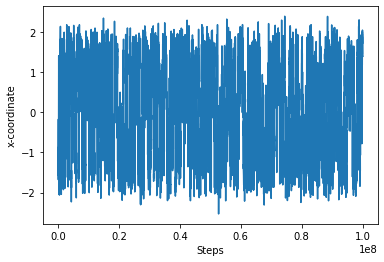

In [12]:
# Plot x-coordinate over time
plt.xlabel('Steps')
plt.ylabel('x-coordinate')
plt.plot(steps, x)

### Testing different Mass/Temperature

In [5]:
# Save simulation results
x1, p_square1, velo1, steps1 = run_simulation(n_steps, 300, 1, 20, 1)

NameError: name 'run_simulation' is not defined

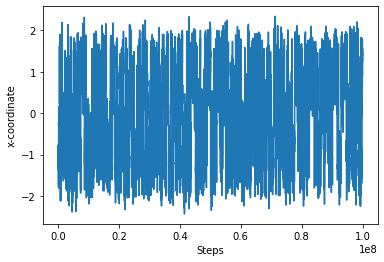

In [8]:
# Plot trajectories
plt.xlabel('Steps')
plt.ylabel('x-coordinate')
plt.plot(steps1, x1)
plt.show()

In [ ]:
# Save simulation results
x2, p_square2, velo2, steps2 = run_simulation(n_steps, 20, 1, 15, 1)

# Plot trajectories
plt.xlabel('Steps')
plt.ylabel('x-coordinate')
plt.plot(steps2, x2)
plt.plot(steps2, velo2)
plt.show()

In [8]:
# Save simulation results
x3, p_square3, velo3, steps3 = run_simulation(n_steps, 1, 1, 1, 1)

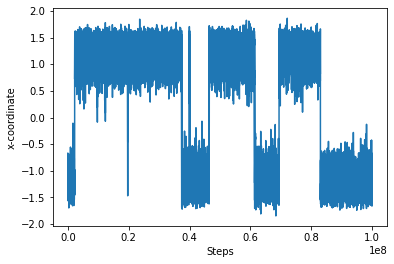

In [9]:
# Plot trajectories
plt.xlabel('Steps')
plt.ylabel('x-coordinate')
plt.plot(steps3, x3)
plt.show()

## Generating Free Energy Surface

When we adiabatically separate the x and y degrees of freedome to generate the marginal distribution of our particle, we are sampling an adiabatic marginal. This marginal is related to the analytical marginal sampled above by the relation:
$$
    P_{adb}(x) = [P(x)]^{T_y/T_x}
$$
I will attempt to use the adiabatic marginal I generated above to replicate the true marginal. I will then try and ascertain the free energy surface of the system. First, I will use the x values I have sampled to create a histogram of how the values are spread across the x degree of freedom.

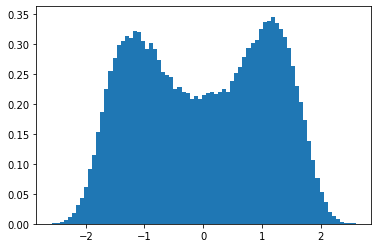

In [36]:
# Calculate histogram for subsampled data
hist, bins = np.histogram(x, bins=75)
bin_width = bins[1] - bins[0]
hist = hist / len(x) * bin_width

# Plot histogram
plt.hist(x, bins=bins, density=True)
plt.show()

From the results, I can calculate a free energy surface with the relation:
$$
    A(x) = -\frac{1}{\beta} ln P(x)
$$
Or, substituting the result above for *P(x)*:
$$
    A(x) = -K_BT ln P_{adb}(x)
$$

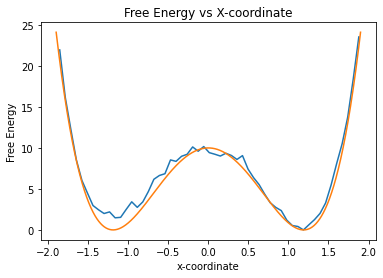

In [38]:
x_coords = (bins[:-1] + bins[1:]) / 2   # Bin centers
y_coords = []   # Free energy

# Transform histogram to FES
for bar in hist:

    # Apply transformation
    transformed_bar = - 20 * np.log(bar)
    y_coords.append(transformed_bar)

new_x = []
new_y = []

# Keep select values
for x, y in zip(x_coords, y_coords):

    # Test if in range
    if x < 1.9 and x > -1.9:

        # Add to list
        new_x.append(x)
        new_y.append(y)

# Minimum to 0
new_y = new_y - min(new_y)
fes = fes - min(fes)

# Plot result
plt.plot(new_x, new_y)
plt.plot(x_list, fes)
plt.xlabel('x-coordinate')
plt.ylabel('Free Energy')
plt.title('Free Energy vs X-coordinate')
plt.show()

## GGMT Temperature Control

Different thermostatting methods can be implemented to simulate simple cases of a particle in a potential well. For the Generalized Gaussian Moment Thermostat (GGMT) method, the equations of motion take the form:
$$
    \dot{x} = \frac{p}{m},\\

    \dot{p} = -m \omega^{2} x - \frac{p_{\eta_{1}}}{Q_1} p - \frac{p_{\eta_{2}}}{Q_2}\left[( kT )p + \frac{p^{3}}{3m} \right] - \frac{p_{\eta_{3}}}{Q_3}\left[( kT )^{2}p + (kT)\frac{p^{3}}{3m} + \frac{p^{5}}{15m^{2}}\right],\\

    \dot{\eta_{1}} = \frac{p_{\eta_{1}}}{Q_1},\\

    \dot{\eta_{2}} = \left[( kT ) + \frac{p^{2}}{m} \right] \frac{p_{\eta_{2}}}{Q_2},\\

    \dot{\eta_{3}} = \left[( kT )^2 + ( kT ) \frac{p^{2}}{m} + \frac{p^{4}}{3m^2}\right] \frac{p_{\eta_{2}}}{Q_2},\\

    \dot{p_{\eta_{1}}} = \frac{p^2}{m} - kT,\\

    \dot{p_{\eta_{2}}} = \frac{p^4}{3m^2} - ( kT )^2,\\
    
    \dot{p_{\eta_{3}}} = \frac{p^6}{15m^3} - ( kT )^3
$$
Symmetric Trotter factorization allows us to express the time propagation of the system, in terms of a Hermitian Liouville operator iL:
$$
    \bm{\Gamma}(t) = e^{iLt}\bm{\Gamma}(0)
$$
where <b>Γ</b> represents the phase space of the system including thermostat variables, into the form:
$$
    e^{iL\Delta t} = e^{\frac{\Delta t}{2} F(q) \frac{\partial}{\partial p}}e^{\frac{\Delta t}{2}\frac{p}{m} \frac{\partial}{\partial q}}e^{iL_{GMMT} \Delta t}e^{\frac{\Delta t}{2}\frac{p}{m} \frac{\partial}{\partial q}} e^{\frac{\Delta t}{2} F(q) \frac{\partial}{\partial p}}
$$
The middle term corresponding to the thermostat variable propagation can be further factorized by Suzuki-Yoshida:
$$
    e^{iL_{GMMT} \Delta t} = \prod_{i=1}^{n_c}\prod_{j=1}^{n_{sv}} e^{iL_{GMMT} \frac{w_j \Delta t}{n_c}}
$$
The code below outlines how one might design a GGMT for a single particle moving in one dimension coupled to a fourth moment thermostat.

In [ ]:
def compute_forces(q):
    '''
    Function to cpmpute forces as the gradient of a potential
    energy function
    '''

    # For harmonic oscillator
    m = 1
    omega = 1
    force = - (m * (omega ** omega) * q)

    # Return force
    return force

def GGMT_integrator(p, p_eta1, p_eta2, q, eta1, eta2, t_step, m, Q1, Q2, kT):
    '''
    Function to integrate the equations of motion corresponding to GGMT,
    fourth moment thermostat is used and the Liouville operator is
    factorized by Trotter and Suzuki-Yoshida factorization

    @param p : particle momentum
    @param p_eta1 : thermostat variable 1 momentum
    @param p_eta2 : thermostat variable 2 momentum
    @param q : particle coordinate
    @param eta1 : thermostat variable 1
    @param eta2 : thermostat variable 2
    @param t_step : time step
    @param m : mass
    @param Q1 : effective thermostat mass 1
    @param Q2 : effective thermostat mass 2
    @param kT : temperature to maintain
    @return updated variables
    '''

    # Constants for GGMT update
    w1 = 1 / (2 - (2 ** (1 / 3)))
    w2 = 1 - (2 * w1)
    w3 = w1
    n_c = 2
    n_sy = [w1, w2, w3]

    # Step 1 : Update momentum (half timestep)
    force = compute_forces(q)
    p = p + (t_step / 2) * force

    # Step 2 : Update position (half timestep)
    q = q + ((t_step * p) / (2 * m))

    # Step 3 : GGMT variable propagator
    # Iterate over 
    for i in range(n_c):
        for w in n_sy:

            # Constants
            dt = (w * t_step) / n_c
            g = kT + ((p ** 2) / m)
            
            # Update thermostat variables
            g_1 = ((p ** 2) / m) - kT
            p_eta1 = p_eta1 + ((dt / 2) * g_1)

            g_2 = ((p ** 4) / (3 * (m ** 2))) - (kT ** 2)
            p_eta2 = p_eta2 + ((dt / 2) * g_2)

            lam = (p_eta1 / Q1) + (kT * (p_eta2 / Q2))
            p = p * np.exp(- (dt / 4) * lam)

            p = p * (1 / (1 + (2 * (p ** 2) * (p_eta2 / (Q2 * 3 * m)) * (dt / 2)))) ** (1 / 2)
            
            lam = (p_eta1 / Q1) + (kT * (p_eta2 / Q2))
            p = p * np.exp(- (dt / 4) * lam)

            eta1 = eta1 * (dt * (p_eta1 / Q1))

            g = kT + ((p ** 2) / m)
            p_eta2 = p_eta2 + ((dt * g * p_eta2) / Q2)

            lam = (p_eta1 / Q1) + (kT * (p_eta2 / Q2)) 
            p = p * np.exp(- (dt / 4) * lam)

            p = p * (1 / (1 + (2 * (p ** 2) * (p_eta2 / (Q2 * 3 * m)) * (dt / 2)))) ** (1 / 2)
 
            lam = (p_eta1 / Q1) + (kT * (p_eta2 / Q2)) 
            p = p * np.exp(- (dt / 4) * lam)

            g_2 = ((p ** 4) / (3 * (m ** 2))) - (kT ** 2)
            p_eta2 = p_eta2 + ((dt / 2) * g_2)

            g_1 = ((p ** 2) / m) - kT
            p_eta1 = p_eta1 + ((dt / 2) * g_1)

    # Step 4 : Update position (full timestep)
    q = q + ((t_step * p) / (2 * m))

    # Step 5 : Update momentum (full timestep)
    force = compute_forces(q)
    p = p + (t_step / 2) * force

    # Return all updated variables
    return p, p_eta1, p_eta2, q, eta1, eta2